In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import KBinsDiscretizer
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [8]:
'''
name  : remove_outlier
desc  : 아웃라이어 제거 
params: df_in: 데이터 프레임
        col_name:제거할 컬럼 이름
return: [제거 된 outlier, 제거 후 df]
'''
def remove_outlier(df_in, col_name):
    # 아웃라이어 범위 설정 
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    # 범위 내의 data만 df_out의 저장 (outlier 제거)
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    
    # 제거된 outlier data들
    idx=[]
    for i in df_in.index:
        if i in df_out.index:
            continue
        else:
            idx.append(i)
    df_outlier = df_in.loc[idx,:]
    
    return [df_outlier, df_out]

In [41]:
'''
name  : plot_roc_curve
desc  : Draw roc curve based on fpr and tpr
params: fpr, tpr
'''
def plot_roc_curve(fpr, tpr):   
    plt.plot(fpr, tpr, color='#4e387e', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [4]:
# Confusion matrix 출력 
def confusion_matrix_heatmap(y_true, y_pred):
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [5]:
'''
name  : doGridSearch
desc  : grid search를 수행하여 score및 best 파라미터 출력 
params: model: 최적화를 수행할 모델 
        parmas: 조정할 파라미터
return: 
'''
def doGridSearch(model_name, model, params):
    # 그리드 서치를 통해 모델 최적화
    print("------------",model_name,"--------------")
    gridCV = GridSearchCV(model, param_grid = params, cv=5, scoring ='roc_auc')
    gridCV.fit(X_train, y_train)
    y_pred = gridCV.predict(X_test)
    
    # SVM의 probability =False인 경우    
    if model_name != 'SVM':
        probs = gridCV.predict_proba(X_test)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test, probs)
        print('AUC: %.6f' % auc)
        
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        plot_roc_curve(fpr, tpr)
    
    # 결과 출력 
    print(classification_report(y_test, y_pred))
    print()
    print("Accuracy:", gridCV.score(X_test, y_test))
    print("Best parameter")
    print(gridCV.best_params_)
    
    return model
    
    

In [7]:
'''
name  : feature_importance
desc  : 로지스틱 기반 변수 중요도 출력 
params: X_train, y_train, X_test, y_test
return: 중요도 dataframe
'''
def feature_importance(X_train, y_train, X_test, y_test):
    # 로지스틱 리그레션 실행 후 평가 확인
    log_rg = LogisticRegression().fit(X_train, y_train)
    cross_val_score(log_rg, X_train, y_train, cv=5)
    log_rg.score(X_test, y_test)
    print(classification_report(y_test, log_rg.predict(X_test)))
    # 변수 중요도 
    feature_importance_lr = pd.DataFrame(zip(X_train.columns.values, abs(log_rg.coef_.ravel())))
    feature_importance_lr.columns = ['feature', 'coef']
    feature_importance_lr.sort_values("coef", ascending=False, inplace=True)
    feature_importance_lr = feature_importance_lr.reset_index().drop(['index'], axis=1)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(feature_importance_lr)
    return feature_importance_lr

In [9]:
'''
name  : feature_importance_2
desc  : decision tree 기반 변수 중요도 출력 
params: X_train, y_train, X_test, y_test
return: 중요도 dataframe
'''
def feature_importance_2(X_train, y_train, X_test, y_test):
    dtree = DecisionTreeClassifier()
    dtree.fit(X_train, y_train)
    return dtree.feature_importances_

In [55]:
#imp

,feature,coef
0,duration,1.192360
1,nr.employed,0.551089
2,emp.var.rate,0.472685
3,contact,0.327757
4,month,0.200888
5,pdays,0.186532
6,default,0.179037
7,cons.price.idx,0.176138
8,poutcome,0.162692
9,euribor3m,0.150321


In [8]:
def drawBoxPlot(data):
    columns = data._get_numeric_data().columns
    size = len(columns)
    count = 0
    
    while size>0:
        if size>=3:
            range_num = 3
        else:
            range_num = size
            
        fig = plt.figure(figsize=(15,5))
        for i in np.arange(range_num)+1:
            axe = fig.add_subplot(1,3,i)
            data.boxplot(column= columns[count])
            count = count+1
        plt.subplots_adjust(top=1, bottom=0, left=0.10, right=0.95, hspace=0.5,
                        wspace=0.5)
        plt.show()
        size = size - 3

In [21]:
#feature_importance(X_train,y_train,X_test,y_test)

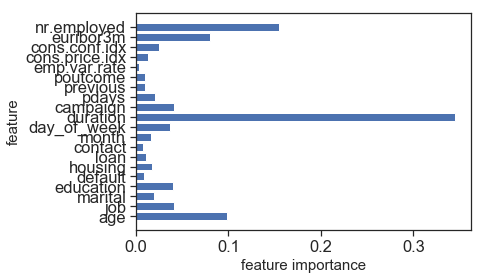

In [66]:
#importance = feature_importance_2(X_train,y_train,X_test,y_test)

# Decision tree 기반 변수 중요도 시각화
#idx = np.arange(20)

#plt.barh(idx, importance, align='center')
#plt.yticks(idx, X.columns)
#plt.xlabel('feature importance', size=15)
#plt.ylabel('feature', size=15)
#plt.show()

In [36]:
def runModel (X_train, y_train, X_test, y_test):
    원본
   
    models = [] 
    #models.append(('Logistic', LogisticRegression()))
   # models.append(('Random Forest', RandomForestClassifier(criterion='entropy', max_depth=10,
                                                          #max_features='auto', n_estimators=700)))
    
    models.append(('Random Forest', RandomForestClassifier()))
    #models.append(('SVM', SVC(probability = True, C= 10, gamma=0.001, kernel = 'linear')))
    # 평가
    results = []
    names = []
    scoring = 'recall'

    seed = 7
    for name, model in models:
        print(model)
        model.fit(X_train, y_train)
        y_predict = pd.Series(model.predict(X_test))

        # Resets index to compare original test data with predicted data
        y_test = y_test.reset_index(drop=True)
        y_predict = y_predict.reset_index(drop=True)


        print('Accuracy',model.score(X_test, y_test))
        print('-' * 50)
        
        if name !='SVM':
            #--------ROC Curve-----------------
            probs = model.predict_proba(X_test)
            probs = probs[:, 1]
            auc = roc_auc_score(y_test, probs)
            
            
            #fpr, tpr, thresholds = roc_curve(y_predict, y_test)
            #roc_auc = auc(fpr, tpr)
            
            print('AUC: %.6f' % auc)

            fpr, tpr, thresholds = roc_curve(y_test, probs)
            plot_roc_curve(fpr, tpr)
            #-----------------------------------

        #-------- Confusion matrix heatmap -----------------
        #confusion_matrix_heatmap(y_test, y_predict)
        print(classification_report(y_test, y_predict))
        #---------------------------------------------------
    
        
    return y_predict

In [38]:
'''
name  : runModel
desc  : After the classification algorithm, we can check the roc curve and the confusion matrix.
        Add the algorithm you want as append.
params: X_train, y_train, X_test, y_test
return: y predict
'''
def runModel (X_train, y_train, X_test, y_test): 
    models = [] 
    models.append(('Logistic', LogisticRegression()))
    models.append(('Random Forest', RandomForestClassifier()))
    models.append(('SVM', SVC(probability = True)))
    
    results = []
    names = []
    scoring = 'recall'

    for name, model in models:
        print(model)
        model.fit(X_train, y_train)
        y_predict = pd.Series(model.predict(X_test))

        # Resets index to compare original test data with predicted data
        y_test = y_test.reset_index(drop=True)
        y_predict = y_predict.reset_index(drop=True)


        print('Accuracy',model.score(X_test, y_test))
        print('-' * 50)
        
  
        #--------ROC Curve-----------------
        probs = model.predict_proba(X_test)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test, probs)
        print('AUC: %.6f' % auc)

        fpr, tpr, thresholds = roc_curve(y_test, probs)
        plot_roc_curve(fpr, tpr)
        #-----------------------------------

        #-------- Confusion matrix heatmap -----------------
        confusion_matrix_heatmap(y_test, y_predict)
        print(classification_report(y_test, y_predict))
        #---------------------------------------------------
    
        
    return y_predict

In [40]:
runModel(X_train, y_train, X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy 0.91442097596504
--------------------------------------------------
AUC: 0.933395


NameError: name 'plot_roc_curve' is not defined

In [8]:
def preprocessing():
    df = pd.read_csv('bank-additional-full.csv', sep = ';')
    df.shape
    
    tempcol = 'age'
    [outlier, df] = remove_outlier(df, tempcol)
    outlier[tempcol].describe()
    
    drawBoxPlot(df['age'])
    
    X=df.drop('y',axis=1) #Predictors
    y=df['y'] #Target
    #X.head()
    
    
    # Train Label Encoding 
    labelencoder = {}
    for i in X.columns:
        # train encoder
        labelencoder[i] = LabelEncoder().fit(X[i])
        # encoding X data 
        X[i] = labelencoder[i].transform(X[i])
        
    scaler = MinMaxScaler()
    #scaler = RobustScaler()

    X[X.select_dtypes(exclude=['object']).columns] = scaler.fit_transform(X[X.select_dtypes(exclude=['object']).columns])
    y = pd.DataFrame(LabelEncoder().fit_transform(y), columns=['y'])
    
    # Logistic 기반 하위 5개
    X.drop(['housing','loan'], axis=1, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify=y)

    return [X_train, X_test, y_train, y_test]

In [13]:
#unknown_col =[]

#for i in df.columns:
#    if len(df.loc[df[i] =='unknown'])>0:
#        print(len(df.loc[df[i] =='unknown']))
#        unknown_col.append(i)

#unknown_col

In [13]:
#num_col= df._get_numeric_data().columns
#num_col

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [ ]:
########################################################################

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')
df.shape

(41188, 21)

In [3]:
# Mode impute
df.loc[df['loan']=='unknown']['loan'] = df['loan'].replace('unknown','no', inplace= True)

In [4]:
# Binning -------------------------------------------------------------------------

# age kemans/5
aa= np.array(df['age']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy = 'kmeans')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['age'] =binning

# campaign kmeans/10
aa= np.array(df['campaign']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 10, encode='ordinal', strategy = 'kmeans')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['campaign'] =binning

# previous quantile/10
aa= np.array(df['previous']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 10, encode='ordinal', strategy = 'quantile')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['previous'] =binning

# emp.var.rate quantile/10
aa= np.array(df['emp.var.rate']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy = 'quantile')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['emp.var.rate'] =binning

# cons.price.idx uniform/10
aa= np.array(df['cons.price.idx']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 10, encode='ordinal', strategy = 'uniform')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['cons.price.idx'] =binning

# cons.conf.idx uniform/5
aa= np.array(df['cons.conf.idx']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy = 'uniform')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['cons.conf.idx'] =binning

#euribor3m  uniform/5
aa= np.array(df['euribor3m']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy = 'uniform')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['euribor3m'] =binning

#nr.employed uniform/5
aa= np.array(df['nr.employed']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy = 'uniform')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['nr.employed'] =binning
#-------------------------------------------------------------------------------------------
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,3,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,999,0,nonexistent,3,6,3,4,4,no
1,3,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,999,0,nonexistent,3,6,3,4,4,no
2,1,services,married,high.school,no,yes,no,telephone,may,mon,...,0,999,0,nonexistent,3,6,3,4,4,no
3,1,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,999,0,nonexistent,3,6,3,4,4,no
4,3,services,married,high.school,no,no,yes,telephone,may,mon,...,0,999,0,nonexistent,3,6,3,4,4,no


In [24]:
# Split data 
X=df.drop('y',axis=1) #Predictors
y=df['y'] #Target

In [25]:
# Train Label Encoding 
labelencoder = {}
for i in X.columns:
    # train encoder
    labelencoder[i] = LabelEncoder().fit(X[i])
    # encoding X data 
    X[i] = labelencoder[i].transform(X[i])

In [26]:
#Standard Scaling
scaler = StandardScaler()
X[X.select_dtypes(exclude=['int32']).columns] = scaler.fit_transform(X[X.select_dtypes(exclude=['int32']).columns])
y = pd.DataFrame(LabelEncoder().fit_transform(y), columns=['y'])

In [27]:
# Delete 4 lower column based on Logistic regression
X.drop(['housing','loan','job','previous'], axis=1, inplace=True)

In [28]:
# Make test dataset 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify=y)

In [29]:
X_train.head()

,age,marital,education,default,contact,month,day_of_week,duration,campaign,pdays,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
14304,-1.048926,2,3,0,0,3,1,1.523266,0.301636,0.191842,1,0.782076,0.517518,-0.502985,0.749006,0.58697
10075,-0.122714,1,3,0,1,4,2,-0.661708,-0.885540,0.191842,1,0.782076,1.656837,-0.502985,0.749006,0.58697
23305,0.803498,1,6,0,0,1,4,1.075388,1.488812,0.191842,1,0.782076,-0.052142,1.079729,0.749006,0.58697
16105,-0.122714,1,3,1,0,3,3,0.702854,-0.885540,0.191842,1,0.782076,0.517518,-0.502985,0.749006,0.58697
22225,1.729710,1,6,1,0,1,2,0.175447,-0.885540,0.191842,1,0.782076,-0.052142,1.079729,0.749006,0.58697


In [33]:
runModel(X_train, y_train, X_test, y_test)

NameError: name 'runModel' is not defined

In [20]:
param_grid = {'penalty' : ['l1', 'l2'],
                 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

------------ Logistic --------------
AUC: 0.933479


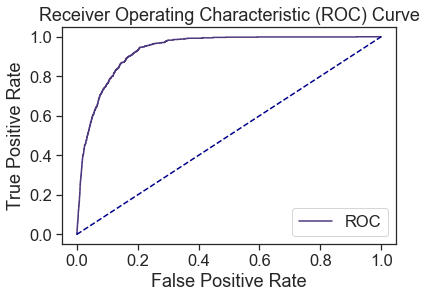

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.69      0.43      0.53       928

    accuracy                           0.91      8238
   macro avg       0.81      0.70      0.74      8238
weighted avg       0.90      0.91      0.91      8238


Accuracy: 0.9334790261333082
Best parameter
{'C': 1000, 'penalty': 'l2'}


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
doGridSearch("Logistic", LogisticRegression(), param_grid)

In [26]:
def doGridSearch(model_name, model, params):
    print("------------",model_name,"--------------")
    gridCV = GridSearchCV(model, param_grid = params, cv=5, scoring ='roc_auc')
    #gridCV = GridSearchCV(model, param_grid = params, cv=5, scoring ='accuracy')
    gridCV.fit(X_train, y_train)
    y_pred = gridCV.predict(X_test)
    
    
    
    if model_name == 'SVM':
        fpr, tpr, thresholds = roc_curve(X_test, y_test)
        roc_auc = auc(fpr, tpr)
        #probs = gridCV.predict_proba(X_test)
        #probs = probs[:, 1]
        #auc = roc_auc_score(y_test, probs)
        print('AUC: %.6f' % roc_auc)
        
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        plot_roc_curve(fpr, tpr)
    
    
    print(classification_report(y_test, y_pred))
    print()
    print("Accuracy:", gridCV.score(X_test, y_test))
    print("Best parameter")
    print(gridCV.best_params_)
    
    return model
    
    

AUC: 0.910647


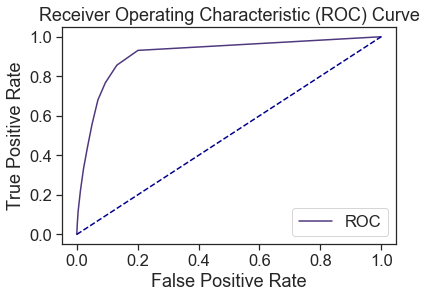

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7310
           1       0.61      0.44      0.51       928

    accuracy                           0.91      8238
   macro avg       0.77      0.70      0.73      8238
weighted avg       0.90      0.91      0.90      8238



In [28]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
probs = rf.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
print('AUC: %.6f' % auc)
        
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(classification_report(y_test, y_pred))

In [33]:
param_grid = { 
    'n_estimators': [200, 500,700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,8,10],
    'criterion' :['gini', 'entropy']
}

------------ RandomForest --------------
AUC: 0.945005


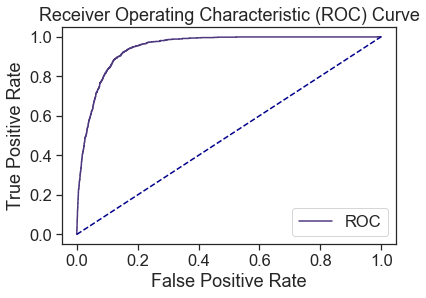

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.72      0.42      0.53       928

    accuracy                           0.92      8238
   macro avg       0.83      0.70      0.74      8238
weighted avg       0.91      0.92      0.91      8238


Accuracy: 0.9450047761686872
Best parameter
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 700}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
doGridSearch("RandomForest", RandomForestClassifier(), param_grid)

In [23]:
#[0.001, 0.01, 0.1, 1]
# 'gamma':[0.001, 0.01, 0.1, 1],

param_grid = {
    'C': [0.01, 0.1],
    'kernel': ['rbf']}

In [27]:
doGridSearch("SVM", SVC(), param_grid)

------------ SVM --------------


ValueError: continuous-multioutput format is not supported

In [215]:
def imbalance (X_train, y_train):

    # 모델설정
    sm = SMOTE(ratio='auto', kind='regular')

    # train데이터를 넣어 복제함
    X_resampled, y_resampled = sm.fit_sample(X_train, y_train)

    print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(X_resampled.shape))

    print("After OverSampling, counts of label '1': {}".format(sum(y_resampled==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_resampled==0)))
    
    return [X_resampled, y_resampled]

In [245]:
re_X, re_y = imbalance(X_train, y_train)

After OverSampling, the shape of train_X: (58476, 16)
After OverSampling, the shape of train_y: (58476, 16) 

After OverSampling, counts of label '1': 29238
After OverSampling, counts of label '0': 29238


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy 0.8755765962612284
--------------------------------------------------
AUC: 0.942014


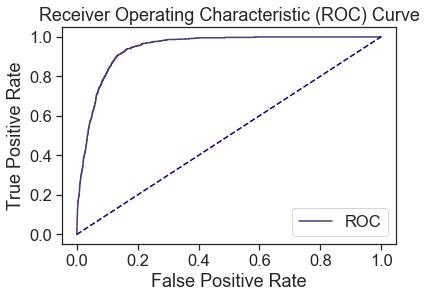

              precision    recall  f1-score   support

           0       0.98      0.87      0.93      7310
           1       0.47      0.89      0.62       928

    accuracy                           0.88      8238
   macro avg       0.73      0.88      0.77      8238
weighted avg       0.93      0.88      0.89      8238



In [246]:
predict = runModel(re_X, re_y, X_test, y_test)

Using TensorFlow backend.


In [68]:
######################################Random Forest로 다시 

In [204]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')
df.shape

(41188, 21)

In [205]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')
df.loc[df['loan']=='unknown']['loan'] = df['loan'].replace('unknown','no', inplace= True)

# age kemans/5
aa= np.array(df['age']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 15, encode='ordinal', strategy = 'kmeans')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['age'] =binning

# campaign kmeans/10
aa= np.array(df['campaign']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 10, encode='ordinal', strategy = 'kmeans')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['campaign'] =binning

# emp.var.rate quantile/10
aa= np.array(df['emp.var.rate']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy = 'quantile')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['emp.var.rate'] =binning

# emp.var.rate quantile/10
aa= np.array(df['cons.price.idx']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 10, encode='ordinal', strategy = 'uniform')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['cons.price.idx'] =binning

# emp.var.rate quantile/10
aa= np.array(df['cons.conf.idx']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy = 'uniform')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['cons.conf.idx'] =binning

aa= np.array(df['euribor3m']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy = 'uniform')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['euribor3m'] =binning

aa= np.array(df['nr.employed']).reshape(-1,1)
enc = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy = 'uniform')
binning = enc.fit_transform(aa).astype('int64').squeeze()
df['nr.employed'] =binning

############################################
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,7,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,999,0,nonexistent,3,6,3,4,4,no
1,7,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,999,0,nonexistent,3,6,3,4,4,no
2,3,services,married,high.school,no,yes,no,telephone,may,mon,...,0,999,0,nonexistent,3,6,3,4,4,no
3,4,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,999,0,nonexistent,3,6,3,4,4,no
4,7,services,married,high.school,no,no,yes,telephone,may,mon,...,0,999,0,nonexistent,3,6,3,4,4,no


In [227]:
X=df.drop('y',axis=1) #Predictors
y=df['y'] #Target
#X.head()

In [228]:
# Train Label Encoding 
labelencoder = {}
for i in X.columns:
    # train encoder
    labelencoder[i] = LabelEncoder().fit(X[i])
    # encoding X data 
    X[i] = labelencoder[i].transform(X[i])
    
#scaler = MinMaxScaler()
scaler = StandardScaler()

X[X.select_dtypes(exclude=['object']).columns] = scaler.fit_transform(X[X.select_dtypes(exclude=['object']).columns])
y = pd.DataFrame(LabelEncoder().fit_transform(y), columns=['y'])

# Logistic 기반 하위 5개
X.drop(['housing','loan','job','previous'], axis=1, inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify=y)
X_train.head()

,age,marital,education,default,contact,month,day_of_week,duration,campaign,pdays,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
14304,-1.351957,1.358578,-0.349730,-0.513600,-0.75857,-0.530547,-0.718834,1.523266,0.301636,0.191842,0.192622,0.782076,0.517518,-0.502985,0.749006,0.58697
10075,0.126312,-0.283741,-0.349730,-0.513600,1.31827,-0.099512,-0.003301,-0.661708,-0.885540,0.191842,0.192622,0.782076,1.656837,-0.502985,0.749006,0.58697
23305,1.111824,-0.283741,1.054464,-0.513600,-0.75857,-1.392618,1.427767,1.075388,1.488812,0.191842,0.192622,0.782076,-0.052142,1.079729,0.749006,0.58697
16105,-0.366445,-0.283741,-0.349730,1.945327,-0.75857,-0.530547,0.712233,0.702854,-0.885540,0.191842,0.192622,0.782076,0.517518,-0.502985,0.749006,0.58697
22225,1.111824,-0.283741,1.054464,1.945327,-0.75857,-1.392618,-0.003301,0.175447,-0.885540,0.191842,0.192622,0.782076,-0.052142,1.079729,0.749006,0.58697


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy 0.9162418062636563
--------------------------------------------------
AUC: 0.945671


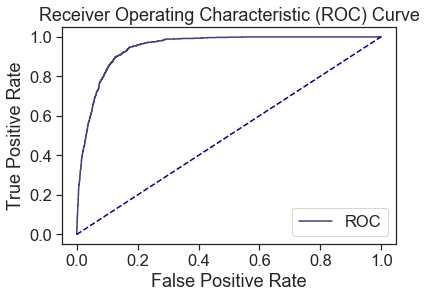

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.69      0.47      0.56       928

    accuracy                           0.92      8238
   macro avg       0.81      0.72      0.76      8238
weighted avg       0.91      0.92      0.91      8238



In [208]:
predict = runModel(X_train, y_train, X_test, y_test)

In [ ]:
col = 'nr.employed'
a = df[col]
aa= np.array(a).reshape(-1,1)

for strategies in ['uniform','quantile','kmeans']:
    # uniform   /  quantile  / kmeans
        
    for j in [5, 10, 15]:
        print("j", j)
        enc = KBinsDiscretizer(n_bins= j, encode='ordinal', strategy = strategies)
        binning = enc.fit_transform(aa).astype('int64').squeeze()
            
        df[col] =binning
            
            
            
        X=df.drop('y',axis=1) #Predictors
        y=df['y'] #Target

        # Train Label Encoding 
        labelencoder = {}
        for i in X.columns:
            # train encoder
            labelencoder[i] = LabelEncoder().fit(X[i])
            # encoding X data 
            X[i] = labelencoder[i].transform(X[i])
                
            
        #scaler = MinMaxScaler()
        scaler = StandardScaler()

        X[X.select_dtypes(exclude=['object']).columns] = scaler.fit_transform(X[X.select_dtypes(exclude=['object']).columns])
        y = pd.DataFrame(LabelEncoder().fit_transform(y), columns=['y'])
            
        X.drop(['housing'], axis=1, inplace=True)
            
            
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify=y)
            
        print(col)
        print(strategies)
        print(j)
        predict = runModel(X_train, y_train, X_test, y_test)
            

In [327]:
# scatter plotting 
def scatterPlot(df, labels):  
    unique_labels = set(labels)

    print(unique_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
   # colors.append([0,0,0,1])
    
    #print(colors)
    
    #print(labels)
    # make color vector
    cvec = [colors[label] for label in labels]
    #cvec = [(0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0), (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0)]
    plt.figure(figsize =(8, 8)) 
    plt.scatter(df['x'], df['y'], c = cvec)  
    plt.show() 
    return